<img width="800px" src="../fidle/img/00-Fidle-header-01.svg"></img>

# <!-- TITLE --> [BHPD2] - Regression with a Dense Network (DNN) - Advanced code
  <!-- DESC -->  A more advanced implementation of the precedent example
  <!-- AUTHOR : Jean-Luc Parouty (CNRS/SIMaP) -->

## Objectives :
 - Predicts **housing prices** from a set of house features. 
 - Understanding the principle and the architecture of a regression with a dense neural network with backup and restore of the trained model. 

The **[Boston Housing Prices Dataset](https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html)** consists of price of houses in various places in Boston.  
Alongside with price, the dataset also provide these information :

 - CRIM: This is the per capita crime rate by town
 - ZN: This is the proportion of residential land zoned for lots larger than 25,000 sq.ft
 - INDUS: This is the proportion of non-retail business acres per town
 - CHAS: This is the Charles River dummy variable (this is equal to 1 if tract bounds river; 0 otherwise)
 - NOX: This is the nitric oxides concentration (parts per 10 million)
 - RM: This is the average number of rooms per dwelling
 - AGE: This is the proportion of owner-occupied units built prior to 1940
 - DIS: This is the weighted distances to five Boston employment centers
 - RAD: This is the index of accessibility to radial highways
 - TAX: This is the full-value property-tax rate per 10,000 dollars
 - PTRATIO: This is the pupil-teacher ratio by town
 - B: This is calculated as 1000(Bk — 0.63)^2, where Bk is the proportion of people of African American descent by town
 - LSTAT: This is the percentage lower status of the population
 - MEDV: This is the median value of owner-occupied homes in 1000 dollars

## What we're going to do :

 - (Retrieve data)
 - (Preparing the data)
 - (Build a model)
 - Train and save the model
 - Restore saved model
 - Evaluate the model
 - Make some predictions


## Step 1 - Import and init

In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os,sys

from IPython.display import Markdown
from importlib import reload

sys.path.append('..')
import fidle.pwk as pwk

datasets_dir = pwk.init('BHPD2')

<br>**FIDLE 2020 - Practical Work Module**

Version              : 2.0.6
Notebook id          : BHPD2
Run time             : Tuesday 26 January 2021, 16:11:13
TensorFlow version   : 2.2.0
Keras version        : 2.3.0-tf
Datasets dir         : /home/pjluc/tmp/datasets
Run dir              : ./run
Update keras cache   : False
Save figs            : True
Path figs            : ./run/figs


## Step 2 - Retrieve data

### 2.1 - Option 1  : From Keras
Boston housing is a famous historic dataset, so we can get it directly from [Keras datasets](https://www.tensorflow.org/api_docs/python/tf/keras/datasets)  

In [2]:
# (x_train, y_train), (x_test, y_test) = keras.datasets.boston_housing.load_data(test_split=0.2, seed=113)

### 2.2 - Option 2 : From a csv file
More fun !

In [3]:
data = pd.read_csv(f'{datasets_dir}/BHPD/origine/BostonHousing.csv', header=0)

display(data.head(5).style.format("{0:.2f}"))
print('Missing Data : ',data.isna().sum().sum(), '  Shape is : ', data.shape)

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.01,18.00,2.31,0.00,0.54,6.58,65.20,4.09,1.00,296.00,15.30,396.90,4.98,24.00
1,0.03,0.00,7.07,0.00,0.47,6.42,78.90,4.97,2.00,242.00,17.80,396.90,9.14,21.60
2,0.03,0.00,7.07,0.00,0.47,7.18,61.10,4.97,2.00,242.00,17.80,392.83,4.03,34.70
3,0.03,0.00,2.18,0.00,0.46,7.00,45.80,6.06,3.00,222.00,18.70,394.63,2.94,33.40
4,0.07,0.00,2.18,0.00,0.46,7.15,54.20,6.06,3.00,222.00,18.70,396.90,5.33,36.20


Missing Data :  0   Shape is :  (506, 14)


## Step 3 - Preparing the data
### 3.1 - Split data
We will use 80% of the data for training and 20% for validation.  
x will be input data and y the expected output

In [4]:
# ---- Split => train, test
#
data_train = data.sample(frac=0.7, axis=0)
data_test  = data.drop(data_train.index)

# ---- Split => x,y (medv is price)
#
x_train = data_train.drop('medv',  axis=1)
y_train = data_train['medv']
x_test  = data_test.drop('medv',   axis=1)
y_test  = data_test['medv']

print('Original data shape was : ',data.shape)
print('x_train : ',x_train.shape, 'y_train : ',y_train.shape)
print('x_test  : ',x_test.shape,  'y_test  : ',y_test.shape)

Original data shape was :  (506, 14)
x_train :  (354, 13) y_train :  (354,)
x_test  :  (152, 13) y_test  :  (152,)


### 3.2 - Data normalization
**Note :** 
 - All input data must be normalized, train and test.  
 - To do this we will subtract the mean and divide by the standard deviation.  
 - But test data should not be used in any way, even for normalization.  
 - The mean and the standard deviation will therefore only be calculated with the train data.

In [5]:
display(x_train.describe().style.format("{0:.2f}").set_caption("Before normalization :"))

mean = x_train.mean()
std  = x_train.std()
x_train = (x_train - mean) / std
x_test  = (x_test  - mean) / std

display(x_train.describe().style.format("{0:.2f}").set_caption("After normalization :"))

x_train, y_train = np.array(x_train), np.array(y_train)
x_test,  y_test  = np.array(x_test),  np.array(y_test)


,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat
count,354.00,354.00,354.00,354.00,354.00,354.00,354.00,354.00,354.00,354.00,354.00,354.00,354.00
mean,3.59,12.51,11.08,0.07,0.56,6.28,68.42,3.81,9.93,416.80,18.41,353.79,12.71
std,7.90,24.26,6.86,0.26,0.12,0.70,28.72,2.18,8.89,167.37,2.23,94.94,6.89
min,0.01,0.00,0.46,0.00,0.39,3.56,2.90,1.17,1.00,187.00,12.60,0.32,1.92
25%,0.08,0.00,4.93,0.00,0.45,5.88,42.95,2.04,4.00,284.25,16.92,373.02,7.12
50%,0.27,0.00,9.69,0.00,0.54,6.18,77.50,3.13,5.00,355.00,19.10,391.34,11.99
75%,3.99,20.00,18.10,0.00,0.65,6.61,94.68,5.37,24.00,666.00,20.20,396.32,17.12
max,73.53,95.00,27.74,1.00,0.87,8.78,100.00,12.13,24.00,711.00,22.00,396.90,34.41


,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat
count,354.00,354.00,354.00,354.00,354.00,354.00,354.00,354.00,354.00,354.00,354.00,354.00,354.00
mean,0.00,0.00,0.00,-0.00,0.00,0.00,0.00,0.00,-0.00,0.00,0.00,-0.00,0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-0.45,-0.52,-1.55,-0.28,-1.44,-3.89,-2.28,-1.21,-1.00,-1.37,-2.60,-3.72,-1.57
25%,-0.44,-0.52,-0.90,-0.28,-0.91,-0.57,-0.89,-0.81,-0.67,-0.79,-0.66,0.20,-0.81
50%,-0.42,-0.52,-0.20,-0.28,-0.16,-0.14,0.32,-0.32,-0.55,-0.37,0.31,0.40,-0.10
75%,0.05,0.31,1.02,-0.28,0.75,0.47,0.91,0.71,1.58,1.49,0.81,0.45,0.64
max,8.85,3.40,2.43,3.62,2.61,3.58,1.10,3.81,1.58,1.76,1.61,0.45,3.15


## Step 4 - Build a model
More informations about : 
 - [Optimizer](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers)
 - [Activation](https://www.tensorflow.org/api_docs/python/tf/keras/activations)
 - [Loss](https://www.tensorflow.org/api_docs/python/tf/keras/losses)
 - [Metrics](https://www.tensorflow.org/api_docs/python/tf/keras/metrics)

In [6]:
  def get_model_v1(shape):
    
    model = keras.models.Sequential()
    model.add(keras.layers.Input(shape, name="InputLayer"))
    model.add(keras.layers.Dense(64, activation='relu', name='Dense_n1'))
    model.add(keras.layers.Dense(64, activation='relu', name='Dense_n2'))
    model.add(keras.layers.Dense(1, name='Output'))
    
    model.compile(optimizer = 'rmsprop',
                  loss      = 'mse',
                  metrics   = ['mae', 'mse'] )
    return model

## 5 - Train the model
### 5.1 - Get it

In [7]:
model=get_model_v1( (13,) )

model.summary()
# img=keras.utils.plot_model( model, to_file='./run/model.png', show_shapes=True, show_layer_names=True, dpi=96)
# display(img)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Dense_n1 (Dense)             (None, 64)                896       
_________________________________________________________________
Dense_n2 (Dense)             (None, 64)                4160      
_________________________________________________________________
Output (Dense)               (None, 1)                 65        
Total params: 5,121
Trainable params: 5,121
Non-trainable params: 0
_________________________________________________________________


### 5.2 - Add callback

In [8]:
os.makedirs('./run/models',   mode=0o750, exist_ok=True)
save_dir = "./run/models/best_model.h5"

savemodel_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_dir, verbose=0, save_best_only=True)

### 5.3 - Train it

In [9]:
history = model.fit(x_train,
                    y_train,
                    epochs          = 100,
                    batch_size      = 10,
                    verbose         = 1,
                    validation_data = (x_test, y_test),
                    callbacks       = [savemodel_callback])

Epoch 1/100


 1/36 [..............................] - ETA: 0s - loss: 789.2297 - mae: 26.3365 - mse: 789.2297

36/36 [==============================] - 0s 5ms/step - loss: 490.1920 - mae: 20.1346 - mse: 490.1920 - val_loss: 400.3235 - val_mae: 17.9279 - val_mse: 400.3235


Epoch 2/100
 1/36 [..............................] - ETA: 0s - loss: 388.5272 - mae: 18.4144 - mse: 388.5272

36/36 [==============================] - 0s 2ms/step - loss: 243.5076 - mae: 13.3676 - mse: 243.5076 - val_loss: 158.8680 - val_mae: 10.3740 - val_mse: 158.8680


Epoch 3/100
 1/36 [..............................] - ETA: 0s - loss: 123.3097 - mae: 9.8418 - mse: 123.3097

35/36 [============================>.] - ETA: 0s - loss: 85.3678 - mae: 6.8011 - mse: 85.3678  

36/36 [==============================] - 0s 3ms/step - loss: 84.6737 - mae: 6.7705 - mse: 84.6737 - val_loss: 62.8453 - val_mae: 5.7651 - val_mse: 62.8453


Epoch 4/100
 1/36 [..............................] - ETA: 0s - loss: 56.9040 - mae: 5.8227 - mse: 56.9040

36/36 [==============================] - 0s 2ms/step - loss: 43.5140 - mae: 4.7684 - mse: 43.5140 - val_loss: 40.7181 - val_mae: 4.4866 - val_mse: 40.7181


Epoch 5/100
 1/36 [..............................] - ETA: 0s - loss: 25.5895 - mae: 4.5046 - mse: 25.5895

36/36 [==============================] - 0s 2ms/step - loss: 29.2399 - mae: 3.9873 - mse: 29.2399 - val_loss: 31.8321 - val_mae: 4.0536 - val_mse: 31.8321


Epoch 6/100
 1/36 [..............................] - ETA: 0s - loss: 28.6131 - mae: 4.2628 - mse: 28.6131

36/36 [==============================] - 0s 2ms/step - loss: 23.7302 - mae: 3.6071 - mse: 23.7302 - val_loss: 28.4820 - val_mae: 3.6431 - val_mse: 28.4820


Epoch 7/100
 1/36 [..............................] - ETA: 0s - loss: 13.4863 - mae: 2.8797 - mse: 13.4863

36/36 [==============================] - 0s 2ms/step - loss: 20.9916 - mae: 3.3302 - mse: 20.9916 - val_loss: 25.1514 - val_mae: 3.5630 - val_mse: 25.1514


Epoch 8/100
 1/36 [..............................] - ETA: 0s - loss: 48.1100 - mae: 5.2588 - mse: 48.1100

36/36 [==============================] - 0s 2ms/step - loss: 18.8880 - mae: 3.1365 - mse: 18.8880 - val_loss: 24.3134 - val_mae: 3.5267 - val_mse: 24.3134


Epoch 9/100
 1/36 [..............................] - ETA: 0s - loss: 41.9494 - mae: 3.8969 - mse: 41.9494

36/36 [==============================] - 0s 2ms/step - loss: 17.4955 - mae: 2.9722 - mse: 17.4955 - val_loss: 20.5042 - val_mae: 3.0310 - val_mse: 20.5042


Epoch 10/100
 1/36 [..............................] - ETA: 0s - loss: 17.7612 - mae: 3.2396 - mse: 17.7612

36/36 [==============================] - 0s 2ms/step - loss: 16.1869 - mae: 2.8582 - mse: 16.1869 - val_loss: 19.0167 - val_mae: 2.9268 - val_mse: 19.0168


Epoch 11/100
 1/36 [..............................] - ETA: 0s - loss: 13.0373 - mae: 3.3431 - mse: 13.0373

36/36 [==============================] - 0s 2ms/step - loss: 15.0167 - mae: 2.7121 - mse: 15.0167 - val_loss: 18.4304 - val_mae: 3.0479 - val_mse: 18.4304


Epoch 12/100
 1/36 [..............................] - ETA: 0s - loss: 12.4242 - mae: 3.2178 - mse: 12.4242

36/36 [==============================] - 0s 2ms/step - loss: 14.2538 - mae: 2.6421 - mse: 14.2538 - val_loss: 17.4586 - val_mae: 2.8057 - val_mse: 17.4586


Epoch 13/100
 1/36 [..............................] - ETA: 0s - loss: 4.7718 - mae: 1.7164 - mse: 4.7718

36/36 [==============================] - 0s 2ms/step - loss: 13.7819 - mae: 2.5986 - mse: 13.7819 - val_loss: 16.9388 - val_mae: 2.7461 - val_mse: 16.9388


Epoch 14/100
 1/36 [..............................] - ETA: 0s - loss: 4.5608 - mae: 1.8071 - mse: 4.5608

36/36 [==============================] - 0s 2ms/step - loss: 12.8846 - mae: 2.5294 - mse: 12.8846 - val_loss: 17.2516 - val_mae: 2.7554 - val_mse: 17.2516


Epoch 15/100
 1/36 [..............................] - ETA: 0s - loss: 5.6014 - mae: 1.9940 - mse: 5.6014

36/36 [==============================] - 0s 2ms/step - loss: 12.6768 - mae: 2.4456 - mse: 12.6768 - val_loss: 16.4361 - val_mae: 2.8082 - val_mse: 16.4361


Epoch 16/100
 1/36 [..............................] - ETA: 0s - loss: 17.0895 - mae: 3.0416 - mse: 17.0895

36/36 [==============================] - 0s 2ms/step - loss: 12.0759 - mae: 2.4669 - mse: 12.0759 - val_loss: 17.0790 - val_mae: 2.8120 - val_mse: 17.0790


Epoch 17/100
 1/36 [..............................] - ETA: 0s - loss: 4.0176 - mae: 1.6579 - mse: 4.0176

36/36 [==============================] - 0s 2ms/step - loss: 11.8501 - mae: 2.3821 - mse: 11.8501 - val_loss: 16.7642 - val_mae: 2.6477 - val_mse: 16.7642


Epoch 18/100
 1/36 [..............................] - ETA: 0s - loss: 5.2755 - mae: 2.1353 - mse: 5.2755

36/36 [==============================] - 0s 2ms/step - loss: 11.2110 - mae: 2.3728 - mse: 11.2110 - val_loss: 15.3097 - val_mae: 2.5568 - val_mse: 15.3097


Epoch 19/100
 1/36 [..............................] - ETA: 0s - loss: 3.6383 - mae: 1.6684 - mse: 3.6383

36/36 [==============================] - 0s 2ms/step - loss: 11.2974 - mae: 2.3447 - mse: 11.2974 - val_loss: 15.3766 - val_mae: 2.6201 - val_mse: 15.3766


Epoch 20/100
 1/36 [..............................] - ETA: 0s - loss: 5.3210 - mae: 2.0364 - mse: 5.3210

36/36 [==============================] - 0s 2ms/step - loss: 11.1116 - mae: 2.3240 - mse: 11.1116 - val_loss: 15.4354 - val_mae: 2.6671 - val_mse: 15.4354


Epoch 21/100
 1/36 [..............................] - ETA: 0s - loss: 22.3915 - mae: 3.1857 - mse: 22.3915

36/36 [==============================] - 0s 2ms/step - loss: 10.7894 - mae: 2.2745 - mse: 10.7894 - val_loss: 15.6384 - val_mae: 2.7457 - val_mse: 15.6384


Epoch 22/100
 1/36 [..............................] - ETA: 0s - loss: 6.4214 - mae: 2.1479 - mse: 6.4214

36/36 [==============================] - 0s 2ms/step - loss: 10.6817 - mae: 2.2611 - mse: 10.6817 - val_loss: 15.9030 - val_mae: 2.6089 - val_mse: 15.9029


Epoch 23/100
 1/36 [..............................] - ETA: 0s - loss: 4.2436 - mae: 1.6992 - mse: 4.2436

36/36 [==============================] - 0s 2ms/step - loss: 10.7614 - mae: 2.2213 - mse: 10.7614 - val_loss: 14.6001 - val_mae: 2.6063 - val_mse: 14.6001


Epoch 24/100
 1/36 [..............................] - ETA: 0s - loss: 25.7706 - mae: 3.5717 - mse: 25.7706

36/36 [==============================] - 0s 2ms/step - loss: 10.2193 - mae: 2.1972 - mse: 10.2193 - val_loss: 15.6784 - val_mae: 2.5965 - val_mse: 15.6784


Epoch 25/100
 1/36 [..............................] - ETA: 0s - loss: 5.5324 - mae: 1.9912 - mse: 5.5324

36/36 [==============================] - 0s 2ms/step - loss: 10.1249 - mae: 2.1809 - mse: 10.1249 - val_loss: 15.2282 - val_mae: 2.5837 - val_mse: 15.2282


Epoch 26/100
 1/36 [..............................] - ETA: 0s - loss: 2.2377 - mae: 1.1077 - mse: 2.2377

36/36 [==============================] - 0s 2ms/step - loss: 9.9233 - mae: 2.1763 - mse: 9.9233 - val_loss: 15.6670 - val_mae: 2.6928 - val_mse: 15.6670


Epoch 27/100
 1/36 [..............................] - ETA: 0s - loss: 11.4387 - mae: 2.7029 - mse: 11.4387

36/36 [==============================] - 0s 2ms/step - loss: 9.6919 - mae: 2.1547 - mse: 9.6919 - val_loss: 14.1283 - val_mae: 2.5286 - val_mse: 14.1283


Epoch 28/100
 1/36 [..............................] - ETA: 0s - loss: 4.8911 - mae: 1.9812 - mse: 4.8911

36/36 [==============================] - 0s 2ms/step - loss: 9.7451 - mae: 2.1941 - mse: 9.7451 - val_loss: 14.1609 - val_mae: 2.5382 - val_mse: 14.1609


Epoch 29/100
 1/36 [..............................] - ETA: 0s - loss: 4.6152 - mae: 1.7277 - mse: 4.6152

36/36 [==============================] - 0s 2ms/step - loss: 9.3923 - mae: 2.1035 - mse: 9.3923 - val_loss: 14.8381 - val_mae: 2.7038 - val_mse: 14.8381


Epoch 30/100
 1/36 [..............................] - ETA: 0s - loss: 7.5951 - mae: 2.3817 - mse: 7.5951

36/36 [==============================] - 0s 2ms/step - loss: 9.3849 - mae: 2.1030 - mse: 9.3849 - val_loss: 13.7527 - val_mae: 2.5303 - val_mse: 13.7527


Epoch 31/100
 1/36 [..............................] - ETA: 0s - loss: 10.3757 - mae: 2.2797 - mse: 10.3757

36/36 [==============================] - 0s 2ms/step - loss: 9.2955 - mae: 2.0881 - mse: 9.2955 - val_loss: 13.9640 - val_mae: 2.4943 - val_mse: 13.9640


Epoch 32/100
 1/36 [..............................] - ETA: 0s - loss: 1.7013 - mae: 1.0237 - mse: 1.7013

36/36 [==============================] - 0s 2ms/step - loss: 8.9611 - mae: 2.0217 - mse: 8.9611 - val_loss: 14.2293 - val_mae: 2.5926 - val_mse: 14.2293


Epoch 33/100
 1/36 [..............................] - ETA: 0s - loss: 29.0072 - mae: 3.0677 - mse: 29.0072

36/36 [==============================] - 0s 2ms/step - loss: 9.0227 - mae: 2.0812 - mse: 9.0227 - val_loss: 14.0698 - val_mae: 2.5126 - val_mse: 14.0698


Epoch 34/100
 1/36 [..............................] - ETA: 0s - loss: 4.3387 - mae: 1.4956 - mse: 4.3387

36/36 [==============================] - 0s 2ms/step - loss: 9.0294 - mae: 2.0612 - mse: 9.0294 - val_loss: 14.0525 - val_mae: 2.6183 - val_mse: 14.0525


Epoch 35/100
 1/36 [..............................] - ETA: 0s - loss: 3.9999 - mae: 1.7044 - mse: 3.9999

36/36 [==============================] - 0s 2ms/step - loss: 8.7516 - mae: 2.0113 - mse: 8.7516 - val_loss: 13.3438 - val_mae: 2.4716 - val_mse: 13.3438


Epoch 36/100
 1/36 [..............................] - ETA: 0s - loss: 9.9559 - mae: 2.1261 - mse: 9.9559

36/36 [==============================] - 0s 2ms/step - loss: 8.5895 - mae: 2.0199 - mse: 8.5895 - val_loss: 14.1211 - val_mae: 2.5441 - val_mse: 14.1211


Epoch 37/100
 1/36 [..............................] - ETA: 0s - loss: 6.2959 - mae: 1.7283 - mse: 6.2959

36/36 [==============================] - 0s 2ms/step - loss: 8.5076 - mae: 2.0127 - mse: 8.5076 - val_loss: 14.9473 - val_mae: 2.6213 - val_mse: 14.9473


Epoch 38/100
 1/36 [..............................] - ETA: 0s - loss: 9.4354 - mae: 2.2976 - mse: 9.4354

36/36 [==============================] - 0s 2ms/step - loss: 8.3655 - mae: 1.9468 - mse: 8.3655 - val_loss: 16.0129 - val_mae: 2.9967 - val_mse: 16.0129


Epoch 39/100
 1/36 [..............................] - ETA: 0s - loss: 7.0406 - mae: 2.2434 - mse: 7.0406

36/36 [==============================] - 0s 2ms/step - loss: 8.3378 - mae: 1.9972 - mse: 8.3378 - val_loss: 12.9133 - val_mae: 2.5104 - val_mse: 12.9133


Epoch 40/100
 1/36 [..............................] - ETA: 0s - loss: 7.8621 - mae: 2.2893 - mse: 7.8621

36/36 [==============================] - 0s 2ms/step - loss: 8.2431 - mae: 1.9952 - mse: 8.2431 - val_loss: 13.2183 - val_mae: 2.4690 - val_mse: 13.2183


Epoch 41/100
 1/36 [..............................] - ETA: 0s - loss: 4.2978 - mae: 1.7720 - mse: 4.2978

36/36 [==============================] - 0s 2ms/step - loss: 8.1977 - mae: 1.9636 - mse: 8.1977 - val_loss: 13.3909 - val_mae: 2.5680 - val_mse: 13.3909


Epoch 42/100
 1/36 [..............................] - ETA: 0s - loss: 7.7478 - mae: 2.3700 - mse: 7.7478

36/36 [==============================] - 0s 2ms/step - loss: 8.2985 - mae: 1.9830 - mse: 8.2985 - val_loss: 13.5719 - val_mae: 2.5750 - val_mse: 13.5719


Epoch 43/100
 1/36 [..............................] - ETA: 0s - loss: 5.0734 - mae: 1.8705 - mse: 5.0734

36/36 [==============================] - 0s 2ms/step - loss: 8.0263 - mae: 1.9229 - mse: 8.0263 - val_loss: 13.7250 - val_mae: 2.5314 - val_mse: 13.7250


Epoch 44/100
 1/36 [..............................] - ETA: 0s - loss: 3.5913 - mae: 1.5571 - mse: 3.5913

36/36 [==============================] - 0s 2ms/step - loss: 7.7840 - mae: 1.9168 - mse: 7.7840 - val_loss: 13.1653 - val_mae: 2.4561 - val_mse: 13.1653


Epoch 45/100
 1/36 [..............................] - ETA: 0s - loss: 6.7348 - mae: 1.9642 - mse: 6.7348

36/36 [==============================] - 0s 2ms/step - loss: 7.8550 - mae: 1.9512 - mse: 7.8550 - val_loss: 12.6144 - val_mae: 2.5175 - val_mse: 12.6144


Epoch 46/100
 1/36 [..............................] - ETA: 0s - loss: 7.1294 - mae: 1.8667 - mse: 7.1294

36/36 [==============================] - 0s 2ms/step - loss: 7.8599 - mae: 1.9569 - mse: 7.8599 - val_loss: 12.6077 - val_mae: 2.4727 - val_mse: 12.6077


Epoch 47/100
 1/36 [..............................] - ETA: 0s - loss: 2.3414 - mae: 1.0427 - mse: 2.3414

36/36 [==============================] - 0s 2ms/step - loss: 7.8154 - mae: 1.8915 - mse: 7.8154 - val_loss: 12.8613 - val_mae: 2.4571 - val_mse: 12.8613


Epoch 48/100
 1/36 [..............................] - ETA: 0s - loss: 1.9289 - mae: 0.9229 - mse: 1.9289

36/36 [==============================] - 0s 2ms/step - loss: 7.4309 - mae: 1.8785 - mse: 7.4309 - val_loss: 14.9141 - val_mae: 2.5885 - val_mse: 14.9141


Epoch 49/100
 1/36 [..............................] - ETA: 0s - loss: 10.4623 - mae: 2.0517 - mse: 10.4623

36/36 [==============================] - 0s 2ms/step - loss: 7.5172 - mae: 1.8802 - mse: 7.5172 - val_loss: 13.3405 - val_mae: 2.5187 - val_mse: 13.3405


Epoch 50/100
 1/36 [..............................] - ETA: 0s - loss: 3.7719 - mae: 1.6304 - mse: 3.7719

36/36 [==============================] - 0s 2ms/step - loss: 7.5482 - mae: 1.8925 - mse: 7.5482 - val_loss: 12.2768 - val_mae: 2.4135 - val_mse: 12.2768


Epoch 51/100
 1/36 [..............................] - ETA: 0s - loss: 6.6832 - mae: 1.8979 - mse: 6.6832

36/36 [==============================] - 0s 2ms/step - loss: 7.3205 - mae: 1.8904 - mse: 7.3205 - val_loss: 12.3155 - val_mae: 2.4075 - val_mse: 12.3155


Epoch 52/100
 1/36 [..............................] - ETA: 0s - loss: 5.1183 - mae: 1.7874 - mse: 5.1183

36/36 [==============================] - 0s 2ms/step - loss: 7.2283 - mae: 1.8878 - mse: 7.2283 - val_loss: 12.6281 - val_mae: 2.3866 - val_mse: 12.6281


Epoch 53/100
 1/36 [..............................] - ETA: 0s - loss: 4.2185 - mae: 1.5925 - mse: 4.2185

36/36 [==============================] - 0s 2ms/step - loss: 7.2048 - mae: 1.8427 - mse: 7.2048 - val_loss: 12.6665 - val_mae: 2.4466 - val_mse: 12.6665


Epoch 54/100
 1/36 [..............................] - ETA: 0s - loss: 46.2204 - mae: 3.7168 - mse: 46.2204

36/36 [==============================] - 0s 2ms/step - loss: 7.0233 - mae: 1.8355 - mse: 7.0233 - val_loss: 12.9432 - val_mae: 2.4135 - val_mse: 12.9432


Epoch 55/100
 1/36 [..............................] - ETA: 0s - loss: 3.3886 - mae: 1.4049 - mse: 3.3886

36/36 [==============================] - 0s 2ms/step - loss: 6.9198 - mae: 1.8756 - mse: 6.9198 - val_loss: 12.0267 - val_mae: 2.3811 - val_mse: 12.0267


Epoch 56/100
 1/36 [..............................] - ETA: 0s - loss: 3.6256 - mae: 1.6881 - mse: 3.6256

36/36 [==============================] - 0s 2ms/step - loss: 7.0188 - mae: 1.8313 - mse: 7.0188 - val_loss: 13.4204 - val_mae: 2.7211 - val_mse: 13.4204


Epoch 57/100
 1/36 [..............................] - ETA: 0s - loss: 3.0646 - mae: 1.5393 - mse: 3.0646

36/36 [==============================] - 0s 2ms/step - loss: 6.8576 - mae: 1.8177 - mse: 6.8576 - val_loss: 11.9274 - val_mae: 2.3876 - val_mse: 11.9274


Epoch 58/100
 1/36 [..............................] - ETA: 0s - loss: 4.7752 - mae: 1.8080 - mse: 4.7752

36/36 [==============================] - 0s 2ms/step - loss: 6.7224 - mae: 1.8302 - mse: 6.7224 - val_loss: 11.7541 - val_mae: 2.3634 - val_mse: 11.7541


Epoch 59/100
 1/36 [..............................] - ETA: 0s - loss: 2.1849 - mae: 1.2227 - mse: 2.1849

36/36 [==============================] - 0s 2ms/step - loss: 6.5203 - mae: 1.8080 - mse: 6.5203 - val_loss: 12.3871 - val_mae: 2.3990 - val_mse: 12.3871


Epoch 60/100
 1/36 [..............................] - ETA: 0s - loss: 6.9132 - mae: 2.2178 - mse: 6.9132

36/36 [==============================] - 0s 2ms/step - loss: 6.6835 - mae: 1.8123 - mse: 6.6835 - val_loss: 12.9390 - val_mae: 2.4603 - val_mse: 12.9390


Epoch 61/100
 1/36 [..............................] - ETA: 0s - loss: 3.9258 - mae: 1.6678 - mse: 3.9258

36/36 [==============================] - 0s 2ms/step - loss: 6.4623 - mae: 1.7705 - mse: 6.4623 - val_loss: 13.1334 - val_mae: 2.5527 - val_mse: 13.1334


Epoch 62/100
 1/36 [..............................] - ETA: 0s - loss: 6.3565 - mae: 2.2262 - mse: 6.3565

36/36 [==============================] - 0s 2ms/step - loss: 6.5736 - mae: 1.7826 - mse: 6.5736 - val_loss: 12.6240 - val_mae: 2.5111 - val_mse: 12.6240


Epoch 63/100
 1/36 [..............................] - ETA: 0s - loss: 3.8692 - mae: 1.5904 - mse: 3.8692

36/36 [==============================] - 0s 2ms/step - loss: 6.6151 - mae: 1.7981 - mse: 6.6151 - val_loss: 12.1113 - val_mae: 2.4282 - val_mse: 12.1113


Epoch 64/100
 1/36 [..............................] - ETA: 0s - loss: 4.4650 - mae: 1.7936 - mse: 4.4650

36/36 [==============================] - 0s 2ms/step - loss: 6.3145 - mae: 1.7612 - mse: 6.3145 - val_loss: 12.0467 - val_mae: 2.5314 - val_mse: 12.0467


Epoch 65/100
 1/36 [..............................] - ETA: 0s - loss: 8.3727 - mae: 2.3840 - mse: 8.3727

36/36 [==============================] - 0s 2ms/step - loss: 6.3090 - mae: 1.7931 - mse: 6.3090 - val_loss: 11.9528 - val_mae: 2.4584 - val_mse: 11.9528


Epoch 66/100
 1/36 [..............................] - ETA: 0s - loss: 2.5810 - mae: 1.2768 - mse: 2.5810

36/36 [==============================] - 0s 2ms/step - loss: 6.2595 - mae: 1.7417 - mse: 6.2595 - val_loss: 11.9418 - val_mae: 2.4955 - val_mse: 11.9418


Epoch 67/100
 1/36 [..............................] - ETA: 0s - loss: 41.1246 - mae: 3.7465 - mse: 41.1246

36/36 [==============================] - 0s 2ms/step - loss: 6.1648 - mae: 1.7757 - mse: 6.1648 - val_loss: 11.3975 - val_mae: 2.3143 - val_mse: 11.3975


Epoch 68/100
 1/36 [..............................] - ETA: 0s - loss: 2.5277 - mae: 1.1879 - mse: 2.5277

36/36 [==============================] - 0s 2ms/step - loss: 6.0316 - mae: 1.7394 - mse: 6.0316 - val_loss: 12.9436 - val_mae: 2.4545 - val_mse: 12.9436


Epoch 69/100
 1/36 [..............................] - ETA: 0s - loss: 4.7709 - mae: 1.8244 - mse: 4.7709

36/36 [==============================] - 0s 2ms/step - loss: 6.0497 - mae: 1.7391 - mse: 6.0497 - val_loss: 12.3473 - val_mae: 2.5819 - val_mse: 12.3473


Epoch 70/100
 1/36 [..............................] - ETA: 0s - loss: 3.5775 - mae: 1.4766 - mse: 3.5775

36/36 [==============================] - 0s 2ms/step - loss: 5.9074 - mae: 1.7288 - mse: 5.9074 - val_loss: 11.5661 - val_mae: 2.3705 - val_mse: 11.5661


Epoch 71/100
 1/36 [..............................] - ETA: 0s - loss: 5.8586 - mae: 2.0126 - mse: 5.8586

36/36 [==============================] - 0s 2ms/step - loss: 5.9333 - mae: 1.7099 - mse: 5.9333 - val_loss: 11.9268 - val_mae: 2.3874 - val_mse: 11.9268


Epoch 72/100
 1/36 [..............................] - ETA: 0s - loss: 1.3440 - mae: 1.0062 - mse: 1.3440

36/36 [==============================] - 0s 2ms/step - loss: 6.0889 - mae: 1.7559 - mse: 6.0889 - val_loss: 11.4048 - val_mae: 2.3403 - val_mse: 11.4048


Epoch 73/100
 1/36 [..............................] - ETA: 0s - loss: 9.2074 - mae: 2.2444 - mse: 9.2074

36/36 [==============================] - 0s 2ms/step - loss: 5.8944 - mae: 1.7038 - mse: 5.8944 - val_loss: 12.5398 - val_mae: 2.5254 - val_mse: 12.5398


Epoch 74/100
 1/36 [..............................] - ETA: 0s - loss: 5.6049 - mae: 1.9092 - mse: 5.6049

36/36 [==============================] - 0s 2ms/step - loss: 5.7702 - mae: 1.6731 - mse: 5.7702 - val_loss: 11.8589 - val_mae: 2.4291 - val_mse: 11.8589


Epoch 75/100
 1/36 [..............................] - ETA: 0s - loss: 11.4862 - mae: 2.8122 - mse: 11.4862

36/36 [==============================] - 0s 2ms/step - loss: 5.6214 - mae: 1.6770 - mse: 5.6214 - val_loss: 13.0445 - val_mae: 2.6862 - val_mse: 13.0445


Epoch 76/100
 1/36 [..............................] - ETA: 0s - loss: 16.1102 - mae: 3.3538 - mse: 16.1102

36/36 [==============================] - 0s 2ms/step - loss: 5.7656 - mae: 1.7123 - mse: 5.7656 - val_loss: 11.1105 - val_mae: 2.3023 - val_mse: 11.1105


Epoch 77/100
 1/36 [..............................] - ETA: 0s - loss: 2.2238 - mae: 1.1720 - mse: 2.2238

36/36 [==============================] - 0s 2ms/step - loss: 5.5032 - mae: 1.6921 - mse: 5.5032 - val_loss: 11.3942 - val_mae: 2.3032 - val_mse: 11.3942


Epoch 78/100
 1/36 [..............................] - ETA: 0s - loss: 4.7189 - mae: 1.7934 - mse: 4.7189

36/36 [==============================] - 0s 2ms/step - loss: 5.4934 - mae: 1.6632 - mse: 5.4934 - val_loss: 11.3899 - val_mae: 2.3005 - val_mse: 11.3899


Epoch 79/100
 1/36 [..............................] - ETA: 0s - loss: 8.2901 - mae: 2.0116 - mse: 8.2901

36/36 [==============================] - 0s 2ms/step - loss: 5.4496 - mae: 1.6426 - mse: 5.4496 - val_loss: 11.0353 - val_mae: 2.3698 - val_mse: 11.0353


Epoch 80/100
 1/36 [..............................] - ETA: 0s - loss: 7.3579 - mae: 1.9061 - mse: 7.3579

36/36 [==============================] - 0s 2ms/step - loss: 5.5562 - mae: 1.6544 - mse: 5.5562 - val_loss: 11.6129 - val_mae: 2.3694 - val_mse: 11.6129


Epoch 81/100
 1/36 [..............................] - ETA: 0s - loss: 2.6983 - mae: 1.3810 - mse: 2.6983

36/36 [==============================] - 0s 2ms/step - loss: 5.4741 - mae: 1.6917 - mse: 5.4741 - val_loss: 11.5591 - val_mae: 2.3489 - val_mse: 11.5591


Epoch 82/100
 1/36 [..............................] - ETA: 0s - loss: 6.9033 - mae: 2.1730 - mse: 6.9033

36/36 [==============================] - 0s 2ms/step - loss: 5.3043 - mae: 1.6494 - mse: 5.3043 - val_loss: 11.0908 - val_mae: 2.3098 - val_mse: 11.0908


Epoch 83/100
 1/36 [..............................] - ETA: 0s - loss: 3.6204 - mae: 1.3808 - mse: 3.6204

36/36 [==============================] - 0s 2ms/step - loss: 5.1877 - mae: 1.6246 - mse: 5.1877 - val_loss: 12.5221 - val_mae: 2.4265 - val_mse: 12.5221


Epoch 84/100
 1/36 [..............................] - ETA: 0s - loss: 5.4169 - mae: 1.9446 - mse: 5.4169

36/36 [==============================] - 0s 2ms/step - loss: 5.4322 - mae: 1.6741 - mse: 5.4322 - val_loss: 11.1412 - val_mae: 2.2819 - val_mse: 11.1412


Epoch 85/100
 1/36 [..............................] - ETA: 0s - loss: 1.8210 - mae: 1.0157 - mse: 1.8210

36/36 [==============================] - 0s 2ms/step - loss: 5.3105 - mae: 1.6562 - mse: 5.3105 - val_loss: 11.9328 - val_mae: 2.4001 - val_mse: 11.9328


Epoch 86/100
 1/36 [..............................] - ETA: 0s - loss: 4.5370 - mae: 1.7690 - mse: 4.5370

36/36 [==============================] - 0s 2ms/step - loss: 5.1209 - mae: 1.5886 - mse: 5.1209 - val_loss: 10.8046 - val_mae: 2.2924 - val_mse: 10.8046


Epoch 87/100
 1/36 [..............................] - ETA: 0s - loss: 4.9659 - mae: 1.6842 - mse: 4.9659

36/36 [==============================] - 0s 2ms/step - loss: 5.1133 - mae: 1.5917 - mse: 5.1133 - val_loss: 11.2856 - val_mae: 2.3395 - val_mse: 11.2856


Epoch 88/100
 1/36 [..............................] - ETA: 0s - loss: 3.0641 - mae: 1.2849 - mse: 3.0641

36/36 [==============================] - 0s 2ms/step - loss: 5.0041 - mae: 1.6101 - mse: 5.0041 - val_loss: 11.0964 - val_mae: 2.3262 - val_mse: 11.0964


Epoch 89/100
 1/36 [..............................] - ETA: 0s - loss: 2.2846 - mae: 1.2575 - mse: 2.2846

36/36 [==============================] - 0s 2ms/step - loss: 4.9866 - mae: 1.5814 - mse: 4.9866 - val_loss: 11.5426 - val_mae: 2.3631 - val_mse: 11.5426


Epoch 90/100
 1/36 [..............................] - ETA: 0s - loss: 6.5598 - mae: 2.2636 - mse: 6.5598

36/36 [==============================] - 0s 2ms/step - loss: 4.7862 - mae: 1.5408 - mse: 4.7862 - val_loss: 10.8012 - val_mae: 2.3194 - val_mse: 10.8012


Epoch 91/100
 1/36 [..............................] - ETA: 0s - loss: 4.5877 - mae: 1.4147 - mse: 4.5877

36/36 [==============================] - 0s 2ms/step - loss: 4.9639 - mae: 1.5621 - mse: 4.9639 - val_loss: 10.9588 - val_mae: 2.4438 - val_mse: 10.9588


Epoch 92/100
 1/36 [..............................] - ETA: 0s - loss: 4.4417 - mae: 1.5357 - mse: 4.4417

36/36 [==============================] - 0s 2ms/step - loss: 4.9230 - mae: 1.5725 - mse: 4.9230 - val_loss: 11.3730 - val_mae: 2.4857 - val_mse: 11.3730


Epoch 93/100
 1/36 [..............................] - ETA: 0s - loss: 3.4063 - mae: 1.3139 - mse: 3.4063

36/36 [==============================] - 0s 2ms/step - loss: 4.8097 - mae: 1.5729 - mse: 4.8097 - val_loss: 12.8997 - val_mae: 2.5450 - val_mse: 12.8997


Epoch 94/100
 1/36 [..............................] - ETA: 0s - loss: 3.8630 - mae: 1.6128 - mse: 3.8630

36/36 [==============================] - 0s 2ms/step - loss: 4.5946 - mae: 1.5054 - mse: 4.5946 - val_loss: 10.6785 - val_mae: 2.2874 - val_mse: 10.6785


Epoch 95/100
 1/36 [..............................] - ETA: 0s - loss: 9.7030 - mae: 1.9510 - mse: 9.7030

36/36 [==============================] - 0s 2ms/step - loss: 4.6245 - mae: 1.5235 - mse: 4.6245 - val_loss: 10.5119 - val_mae: 2.2557 - val_mse: 10.5119


Epoch 96/100
 1/36 [..............................] - ETA: 0s - loss: 6.5622 - mae: 1.7688 - mse: 6.5622

36/36 [==============================] - 0s 2ms/step - loss: 4.6283 - mae: 1.5389 - mse: 4.6283 - val_loss: 11.0924 - val_mae: 2.3161 - val_mse: 11.0924


Epoch 97/100
 1/36 [..............................] - ETA: 0s - loss: 9.9376 - mae: 2.1553 - mse: 9.9376

36/36 [==============================] - 0s 2ms/step - loss: 4.7585 - mae: 1.5580 - mse: 4.7585 - val_loss: 12.1603 - val_mae: 2.4097 - val_mse: 12.1603


Epoch 98/100
 1/36 [..............................] - ETA: 0s - loss: 2.5867 - mae: 1.2264 - mse: 2.5867

36/36 [==============================] - 0s 2ms/step - loss: 4.6709 - mae: 1.5014 - mse: 4.6709 - val_loss: 11.0388 - val_mae: 2.2822 - val_mse: 11.0388


Epoch 99/100
 1/36 [..............................] - ETA: 0s - loss: 2.1308 - mae: 1.2632 - mse: 2.1308

36/36 [==============================] - 0s 2ms/step - loss: 4.7336 - mae: 1.5488 - mse: 4.7336 - val_loss: 11.7667 - val_mae: 2.3805 - val_mse: 11.7667


Epoch 100/100
 1/36 [..............................] - ETA: 0s - loss: 9.0234 - mae: 2.3488 - mse: 9.0234

36/36 [==============================] - 0s 2ms/step - loss: 4.4814 - mae: 1.5239 - mse: 4.4814 - val_loss: 10.8222 - val_mae: 2.3810 - val_mse: 10.8222


## Step 6 - Evaluate
### 6.1 - Model evaluation
MAE =  Mean Absolute Error (between the labels and predictions)  
A mae equal to 3 represents an average error in prediction of $3k.

In [10]:
score = model.evaluate(x_test, y_test, verbose=0)

print('x_test / loss      : {:5.4f}'.format(score[0]))
print('x_test / mae       : {:5.4f}'.format(score[1]))
print('x_test / mse       : {:5.4f}'.format(score[2]))

x_test / loss      : 10.8222
x_test / mae       : 2.3810
x_test / mse       : 10.8222


### 6.2 - Training history
What was the best result during our training ?

In [11]:
print("min( val_mae ) : {:.4f}".format( min(history.history["val_mae"]) ) )

min( val_mae ) : 2.2557


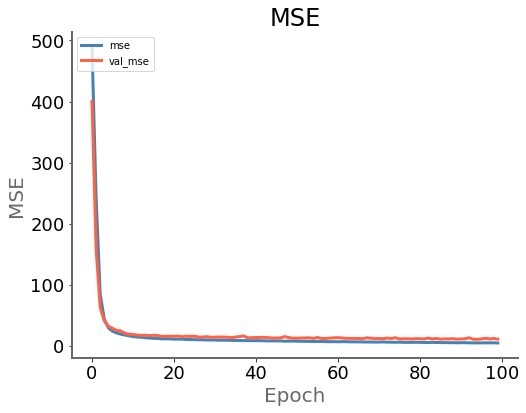

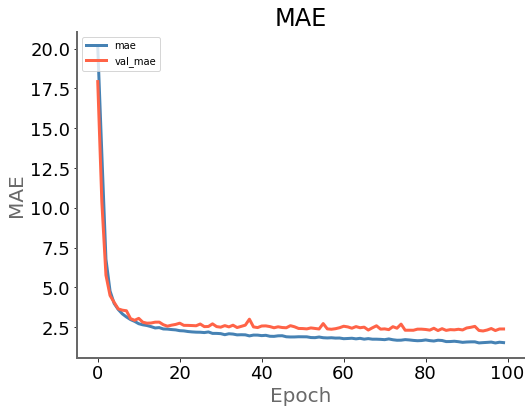

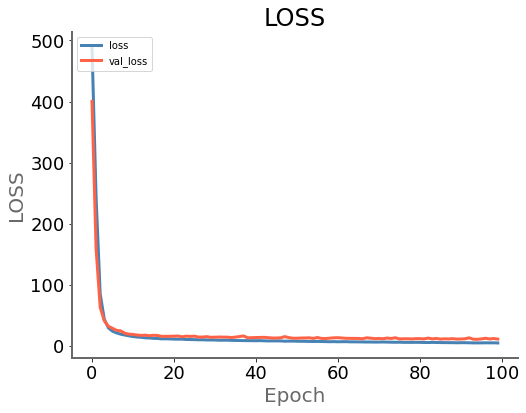

In [12]:
pwk.plot_history(history, plot={'MSE' :['mse', 'val_mse'],
                                'MAE' :['mae', 'val_mae'],
                                'LOSS':['loss','val_loss']}, save_as='01-history')

## Step 7 - Restore a model :

### 7.1 - Reload model

In [13]:
loaded_model = tf.keras.models.load_model('./run/models/best_model.h5')
loaded_model.summary()
print("Loaded.")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Dense_n1 (Dense)             (None, 64)                896       
_________________________________________________________________
Dense_n2 (Dense)             (None, 64)                4160      
_________________________________________________________________
Output (Dense)               (None, 1)                 65        
Total params: 5,121
Trainable params: 5,121
Non-trainable params: 0
_________________________________________________________________
Loaded.


### 7.2 - Evaluate it :

In [14]:
score = loaded_model.evaluate(x_test, y_test, verbose=0)

print('x_test / loss      : {:5.4f}'.format(score[0]))
print('x_test / mae       : {:5.4f}'.format(score[1]))
print('x_test / mse       : {:5.4f}'.format(score[2]))

x_test / loss      : 10.5119
x_test / mae       : 2.2557
x_test / mse       : 10.5119


### 7.3 - Make a prediction

In [15]:
my_data = [ 1.26425925, -0.48522739,  1.0436489 , -0.23112788,  1.37120745,
       -2.14308942,  1.13489104, -1.06802005,  1.71189006,  1.57042287,
        0.77859951,  0.14769795,  2.7585581 ]
real_price = 10.4

my_data=np.array(my_data).reshape(1,13)

In [16]:
predictions = loaded_model.predict( my_data )
print("Prediction : {:.2f} K$   Reality : {:.2f} K$".format(predictions[0][0], real_price))

Prediction : 8.55 K$   Reality : 10.40 K$


In [17]:
pwk.end()

End time is : Tuesday 26 January 2021, 16:11:23
Duration is : 00:00:10 812ms
This notebook ends here


---
<img width="80px" src="../fidle/img/00-Fidle-logo-01.svg"></img>